This is a summary and cleaner version of the jupyter lab called: http://127.0.0.1:8888/lab/tree/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Get_data_for_modeing_3.ipynb

In this juper lab: 

    1. I first create a LSTM mode, with one input which are IFR of has two output : Sin and Cos of the angle of the animal around the lever
    2. Load the ifr of the cells (Mostly FS) and sin and cos of the angle of the animal around the lever 
    3. Generate the the model and get the labels and output and calculate the mse of the model 
    4. Reconstruct the angle of the animal around the lever and compare it to the predicted angle from the model 
    5. Calculate the shuffle value for angle of the animal around the lever and run the model on shuffled data. 
    6. Compare the r and mse from the shufled data with the original data. 
    
    7. Repeat this for all the sessions with at least 10 FS
    

Here I mostly wanted to load the result from the shuffeling and check if they worked for the sessions where the shuffling worked .. its in Shuffled_values forder

In [157]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
#prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[64:67],myProject.sessionList[64:67]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.81s/it]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [4]:
#for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
#for ses, sSes in tqdm(zip(myProject.sessionList[64:67],sSessions[64:67])):
    getSearchHomingIntervals(ses, sSes)

2it [00:00, 18.93it/s]


In [5]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)

res = pd.read_csv(fn)
###
df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 198 ms, sys: 8.43 ms, total: 206 ms
Wall time: 205 ms


In [6]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    
    return sSes,ses,n, nid 


In [7]:
def load_pose_around_lever_for_modeling(ses,sSes, interName= 'all_light' ,maxDistance= 18, rotationType="none", 
                                        invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12, ctype= 'fs' ):

    sSes.load_parameters_from_files()
    sSes.load_parameters_from_files()
    sSes.ap.load_pose_from_file() # get original hd data,

    ## Transfer the x,y position of the animal to the Lever Reference frame 
    toLeverReferenceFrame(ses=ses,sSes=sSes,maxDistance=maxDistance, rotationType="none", invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12)

    sSes.ap.set_intervals(ses.intervalDict[interName])
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(sSes)
    cg = Cell_group(stl, sSes.ap)

    # create a list of cells (spikeA.Neuron)
    if ctype== 'fs' :
        cids = cells[(cells.session == sSes.name) & (cells.mrate_RF1> 10) & (cells.interneuron)].cluId

    elif ctype== 'gc':
        cids = cells[(cells.session == sSes.name) & (cells.gridCell_FIRST)].cluId
    else:
        cids = cells[(cells.session == sSes.name)].cluId

    cIds = [cid.split("_")[1] for cid in cids]
    cg.sc_list = [n for n in cg.neuron_list if n.name in cIds]

    return sSes.ap, cg

In [8]:
def get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses,interName= 'all_light', ctype= 'fs',  sigma_ifr= 5, maxDistance= 18, rotationType="none" ):
    """
    Get ifr  and the movement direction of the animal that matches the ap.pose samples
    
    """
    # load session files
    ap, cg = load_pose_around_lever_for_modeling(ses,sSes, interName= interName,maxDistance= maxDistance, rotationType=rotationType, 
                                        invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12, ctype= ctype)
    
    # trick to get aligned ifr and pose data
    time = ap.pose[:,0]
    bin_size_sec = np.diff(time)[0]
    
    pose = ap.pose[:,1:3]
    keepIndices = ~(np.isnan(pose[:,1]))
    pose= pose[keepIndices]
    
    angles = np.arctan2(pose[:,1], pose[:,0]) ## get values between -3,3 
    magnitude = np.sqrt(pose[:,0]**2 + pose[:,1]**2)
    #angles = np.mod(angles + 2 * np.pi, 2 * np.pi) ## get values between 0, 2*pi
    # Compute the sine and cosine of the angle
    sin_angle = pose[:,1] / magnitude
    cos_angle = pose[:,0] / magnitude

    sin_cos_angles = np.column_stack((sin_angle, cos_angle))
    
    if len(cg.sc_list)!= 0:

        for n in cg.sc_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            n.spike_train.instantaneous_firing_rate(bin_size_sec = bin_size_sec, sigma= sigma_ifr, time_start=min(time)-bin_size_sec/2, 
                                                time_end=max(time), outside_interval_solution="remove")

       
        ifr = np.stack([n.spike_train.ifr[0][keepIndices] for n in cg.sc_list])

        #### aligne the shape 
        time = time[keepIndices]
        ifr= ifr[:,:-1]
        time= time[:-1]
 
    else:
        ifr= np.nan
        time= time[:-1]

    return ifr, pose[:-1,:], time, angles[:-1], sin_cos_angles[:-1,:]

# Build the lstm model 


In [9]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import mean_squared_error 
import datetime


class NeuralDataset(torch.utils.data.Dataset):
    """
    Represent our pose and neural data.
    
    """
    def __init__(self, ifr, sin, cos, time, seq_length,ifr_normalization_means=None,ifr_normalization_stds=None):    
        """
        ifr: instantaneous firing rate
        angle: angle of the animal around the lever from -pi to pi 
        seq_length: length of the data passed to the network
        """
        super(NeuralDataset, self).__init__()
        self.ifr = ifr.astype(np.float32)
        #self.sin_cos_angles = sin_cos_angles.astype(np.float32)
        self.sin = sin.astype(np.float32)
        self.cos= cos.astype(np.float32)
        self.time = time.astype(np.float32)
        self.seq_length = seq_length
        
        self.ifr_normalization_means=ifr_normalization_means
        self.ifr_normalization_stds=ifr_normalization_stds
        
        self.normalize_ifr()
        
        #self.validIndices = np.argwhere(~np.isnan(self.angel[:]))
        self.validIndices = np.argwhere(~np.isnan(self.sin[:]))
        self.validIndices = self.validIndices[self.validIndices>seq_length] # make sure we have enough neural dat leading to the angles
   
        
    def normalize_ifr(self):
        """
        Set the mean of each neuron to 0 and std to 1
        Neural networks work best with inputs in this range
        Set maximal values at -5.0 and 5 to avoid extreme data points
        
        ###########
        # warning #
        ###########
        
        In some situation, you should use the normalization of the training set to normalize your test set.
        For instance, if the test set is very short, you might have a very poor estimate of the mean and std, or the std might be undefined if a neuron is silent.
        """
        if self.ifr_normalization_means is None:
            self.ifr_normalization_means = self.ifr.mean(axis=0)
            self.ifr_normalization_stds = self.ifr.std(axis=0)
            
        self.ifr = (self.ifr-np.expand_dims(self.ifr_normalization_means,0))/np.expand_dims(self.ifr_normalization_stds,axis=0)
        self.ifr[self.ifr> 5.0] = 5.0
        self.ifr[self.ifr< -5.0] = -5.0
        
        
    def __len__(self):
        return len(self.validIndices)
    
    def __getitem__(self,index):
        """
        Function to get an item from the dataset
        
        Returns angles, neural data
        
        """
        neuralData = self.ifr[self.validIndices[index]-self.seq_length:self.validIndices[index],:]
        #sin_cos_angles = self.angle[self.validIndices[index]:self.validIndices[index]+1,:]#. 2d array 
        sin= self.sin[self.validIndices[index]:self.validIndices[index]+1].squeeze()  # Squeeze to get shape [1] instead of [1, 1]
        cos= self.cos[self.validIndices[index]:self.validIndices[index]+1].squeeze()  # Squeeze to get shape [1] instead of [1, 1]
        time = self.time[self.validIndices[index]:self.validIndices[index]+1]
        
        #return torch.from_numpy(neuralData), torch.from_numpy(sin_cos_angles).squeeze(), torch.from_numpy(time) # if I return sin_cos_angle in a 2d array
        return torch.from_numpy(neuralData), torch.from_numpy(sin), torch.from_numpy(cos), torch.from_numpy(time)
    
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_outputs, sequence_length, device):
        super(LSTM,self).__init__()
        """
        For more information about nn.LSTM -> https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        """
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size,hidden_size, num_layers, batch_first=True)
        # input : batch_size x sequence x features
        self.device = device
        self.fc = torch.nn.Linear(hidden_size*sequence_length, num_outputs) # if you onely want to use the last hidden state (hidden_state,num_classes)
        #self.fc = torch.nn.Linear(hidden_size * sequence_length, 2)  # Output two values for sin and cos but in a single 2d array  
        
    def forward(self,x):
        
        h0 =  torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(self.device)
        c0 =  torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(self.device) 
        out, _ = self.lstm(x,(h0,c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out) #if you want to use only the last hidden state, remove previous line, # out = self.fc(out[:,-1,:])
        
        return out

In [10]:
def split_to_test_andTraining(ifr, pose, sin_cos_angles, time, angles):

    split_index = int(ifr.shape[1] * 0.8)  # 80% of the data along the second axis
    train_ifr = ifr[:, :split_index]  # First 80% for training
    test_ifr = ifr[:, split_index:]
    
    train_pose= pose[:split_index, :]
    test_pose= pose[split_index:, :]
    
    train_sin_cos_angles= sin_cos_angles[:split_index, :]
    test_sin_cos_angles= sin_cos_angles[split_index:, :]
    
    train_time=time[:split_index]
    test_time= time[split_index:]
    
    train_angles=angles[:split_index]
    test_angles= angles[split_index:]
    
    return train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles

import numpy as np

def get_shuffled_data(interName, sin_cos_angles, ses, min_roll_sec=20):
    # Get the interval times for the specified interName
    intervals = ses.intervalDict[interName]
    total_time_sec = intervals[:, 1][-1] - intervals[:, 0][0]

    # Ensure the total interval duration is larger than 2 * min_roll_sec
    if total_time_sec < 2 * min_roll_sec:
        raise ValueError("Total time in intervals should be larger than 2 * min_roll_sec")

    # Generate a random shift within the allowed range
    time_shift = np.random.default_rng().uniform(min_roll_sec, total_time_sec - min_roll_sec, 1)
    angles = np.arctan2(sin_cos_angles[:, 0], sin_cos_angles[:, 1])

    # Calculate time per data point
    time_per_datapoint = angles[1] - angles[0]
    shift = int(time_shift / time_per_datapoint)

    # Apply the shift to the angles
    rolled_angles = np.roll(angles, shift=shift, axis=0)

    # Convert the shifted angles back to sin and cos components
    rolled_sin_cos = np.column_stack((np.sin(rolled_angles), np.cos(rolled_angles)))

    return rolled_sin_cos


In [11]:
def get_test_training_datas_oneSession(sSes, ses, interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none", shuffle=True):

    # 1. Split the time interval for training and testing
    intervals= ses.intervalDict[interName]
    ifr, pose, time, angles, sin_cos_angles = get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses, interName= interName, ctype= ctype,  sigma_ifr= sigma_ifr, maxDistance= maxDistance, rotationType= rotationType )
    
    if shuffle: 
        sin_cos_angles_shuffled= get_shuffled_data( interName, sin_cos_angles,ses, min_roll_sec=20)
        train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles = split_to_test_andTraining(ifr,
                                pose, sin_cos_angles_shuffled, time, angles)
        train_ifr = train_ifr.T 
        test_ifr = test_ifr.T

    
    else: 
        
        train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles = split_to_test_andTraining(ifr, pose, sin_cos_angles, time, angles)
        train_ifr = train_ifr.T 
        test_ifr = test_ifr.T
    
    ####################
    ### Get the config file 
    #############
    ###################

    config = {"seq_length":20, ## is this the length of the 
              "n_cells": train_ifr.shape[1], ## it was the num of cells for one neuron is always 1
              "hidden_size" :256,
              "num_layers" : 2,
              "num_outputs" : 2, # 2 number of vector unit in x and y since I want to calculate the movement direction 
              "learning_rate" : 0.001,#0.001, ## 0.001 ( sme was )
              "dropout_rate": 0.05,
              "batch_size" :64, #64,
              "num_epochs": 100}

    print(datetime.datetime.now(), config)
    #print(datetime.now(), config)
    # 4. Create train and test datasets
    train_dataset = NeuralDataset(
        ifr=train_ifr[:, :config["n_cells"]],
        #angle=train_angles,
        sin= train_sin_cos_angles[:,0], ### instead of 
        cos= train_sin_cos_angles[:,1],
        time=train_time,
        seq_length=config["seq_length"]
    )

    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds

    myDict = {
        "ifr_normalization_means": ifr_normalization_means,
        "ifr_normalization_stds": ifr_normalization_stds
    }

    test_dataset = NeuralDataset(
        ifr=test_ifr[:, :config["n_cells"]],
        #angle=test_angles,
        sin= test_sin_cos_angles[:,0],
        cos= test_sin_cos_angles[:,1],
        time=test_time,
        seq_length=config["seq_length"],
        ifr_normalization_means=ifr_normalization_means,
        ifr_normalization_stds=ifr_normalization_stds)

    # 5. Create data loaders
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config["batch_size"],
        num_workers=1, shuffle=True, pin_memory=False, drop_last=True)

    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config["batch_size"],
        num_workers=1, shuffle=False, pin_memory=False)

    return train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config

def lossOnTestDataset(model, test_data_loader, device, loss_fn):
    model.eval()
    loss_test = 0
    with torch.no_grad():
        for imgs, sin_labels, cos_labels, time in test_data_loader:
            imgs = imgs.to(device)
            sin_labels = sin_labels.to(device)
            cos_labels = cos_labels.to(device)

            outputs = model(imgs)  # Model outputs both sin and cos
            
            # Assume outputs[:, 0] is for sin and outputs[:, 1] is for cos
            sin_outputs = outputs[:, 0]
            cos_outputs = outputs[:, 1]

            # Calculate loss for both sin and cos
            loss_sin = loss_fn(sin_outputs, sin_labels)
            loss_cos = loss_fn(cos_outputs, cos_labels)
            
            # Total loss (sum of both)
            loss = loss_sin + loss_cos
            loss_test += loss.item()
    
    model.train()  # Set model back to training mode
    
    if len(test_data_loader) == 0:  # Handle case where the loader is empty
        return float('inf')  # Or return some placeholder value to indicate no test data
    
    return loss_test / len(test_data_loader)


def training_loop(n_epochs,
                  optimizer,
                  model,
                  loss_fn,
                  train_data_loader,
                  test_data_loader,
                  config,
                  device,
                  verbose=False,
                  best_loss=float('inf'),
                  best_model_state=None):
    
    if verbose:
        print("Training starting at {}".format(datetime.datetime.now()))
    
    # Evaluate initial loss without training
    testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)
    trainLoss = lossOnTestDataset(model, train_data_loader, device, loss_fn)
    
    if verbose:
        print(f"Test loss without training: {testLoss}")
    
    df = pd.DataFrame({
        "epochs": [0],
        "seq_length": config["seq_length"],
        "n_cells": config["n_cells"],
        "hidden_size": config["hidden_size"],
        "num_layers": config["num_layers"],
        "learning_rate": config["learning_rate"],
        "batch_size": config["batch_size"],
        "train_loss": trainLoss,
        "test_loss": testLoss
    })

    for epoch in range(1, n_epochs + 1):
        loss_train = 0
        model.train()  # Set model to training mode

        for imgs, sin_labels, cos_labels, time in train_data_loader:  # Expect 4 values
            imgs = imgs.to(device)
            sin_labels = sin_labels.to(device).squeeze()  # Ensure sin_labels shape is [64] instead of [64, 1]
            cos_labels = cos_labels.to(device).squeeze()  # Ensure cos_labels shape is [64] instead of [64, 1]

            # Forward pass
            outputs = model(imgs)  # Model outputs both sin and cos
            sin_outputs = outputs[:, 0]  # First output is sin
            cos_outputs = outputs[:, 1]  # Second output is cos

            # Compute losses for both sin and cos predictions
            loss_sin = loss_fn(sin_outputs, sin_labels)
            loss_cos = loss_fn(cos_outputs, cos_labels)

            # Total loss as the sum of both
            loss = loss_sin + loss_cos

            optimizer.zero_grad()  # Clear gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            loss_train += loss.item()  # Accumulate loss
        
        # Calculate loss on test set
        testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)

        if verbose:
            print(f"{datetime.datetime.now()} Epoch: {epoch}/{n_epochs}, "
                  f"Training loss: {loss_train/len(train_data_loader)}, "
                  f"Testing loss: {testLoss}")

        # Record training statistics
        df1 = pd.DataFrame({
            "epochs": [epoch],
            "seq_length": config["seq_length"],
            "n_cells": config["n_cells"],
            "hidden_size": config["hidden_size"],
            "num_layers": config["num_layers"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "train_loss": loss_train / len(train_data_loader),
            "test_loss": testLoss
        })

        df = pd.concat([df, df1])

        # Save the best model state based on test loss
        if testLoss < best_loss:
            best_loss = testLoss
            best_model_state = model.state_dict()

    return df, best_model_state


In [12]:
def Makeprediction(model, test_data_loader, device):
    model.eval()
    labellists_sin = []
    labellists_cos = []
    outputlists_sin = []
    outputlists_cos = []
    
    with torch.no_grad():
        for imgs, sin_labels, cos_labels, time in test_data_loader:  # mini-batches with data loader
            imgs = imgs.to(device=device)
            
            # Move labels to CPU
            sin_labels = sin_labels.to('cpu').numpy()
            cos_labels = cos_labels.to('cpu').numpy()
            
            # Predict outputs
            outputs = model(imgs)
            sin_outputs = outputs[:, 0].to('cpu').detach().numpy()  # First output: sin
            cos_outputs = outputs[:, 1].to('cpu').detach().numpy()  # Second output: cos

            # Append predictions and labels
            outputlists_sin.append(sin_outputs)
            outputlists_cos.append(cos_outputs)
            labellists_sin.append(sin_labels)
            labellists_cos.append(cos_labels)
    
    return labellists_sin, labellists_cos, outputlists_sin, outputlists_cos

def get_labels_and_outputs_mse(model, test_data_loader, device):
    ''' 
        This is a func to run the models on the slected cell types and
        returns:
        
         1. mean square error of the model
         2. labesl and the outputs (concatenated for the selected cells)
         
    '''
    
    #labellists, outputlists = Makeprediction(model,test_data_loader,device=device)
    labellists_sin, labellists_cos, outputlists_sin, outputlists_cos= Makeprediction(model, test_data_loader, device)
    labels_sin= np.concatenate(labellists_sin)
    labels_cos= np.concatenate(labellists_cos)
    outputs_sin= np.concatenate(outputlists_sin)
    outputs_cos= np.concatenate(outputlists_cos)
        
    outputs= np.column_stack((outputs_sin, outputs_cos))
    labels= np.column_stack((labels_sin, labels_cos))
    
    mse_sin= mean_squared_error(labels_sin,outputs_sin) 
    mse_cos= mean_squared_error(labels_cos,outputs_cos)
    
    #mse= np.column_stack((mse_sin, mse_cos))
    mse = (mse_sin, mse_cos)
    
    return mse, outputs, labels

Need to modify the the func to get the test and training dataset with the possibility to get the shuffled value 

In [17]:
sigma_ifr= 5
ses= myProject.sessionList[152]
sSes= sSessions[152]

ctype= 'fs'
interName= 'atLever_light'
maxDistance= 18 
rotationType= 'none'

#intervals= ses.intervalDict[interName]

## get test and training dataset
train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses,
                                                    interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none", shuffle=False)
### get my model 
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
print("Device available:", device)

#optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
loss_fn = torch.nn.MSELoss() # 
model.train()


### train the model 
df, best_model_state = training_loop(n_epochs=config["num_epochs"],
             optimizer=optimizer,
             model = model,
             loss_fn = loss_fn,
             train_data_loader=train_data_loader,
             test_data_loader=test_data_loader, #changed to look at prediction in training dataset
             config=config,
             device = device,
             verbose=True)

2024-11-07 09:10:43.788093 {'seq_length': 20, 'n_cells': 14, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
Device available: cuda
Training starting at 2024-11-07 09:10:45.916183
Test loss without training: 1.000929022828738
2024-11-07 09:10:47.002673 Epoch: 1/100, Training loss: 0.9837802021453778, Testing loss: 0.9747901211182276
2024-11-07 09:10:47.597377 Epoch: 2/100, Training loss: 0.9608669976393381, Testing loss: 0.9550281514724096
2024-11-07 09:10:48.164568 Epoch: 3/100, Training loss: 0.9408023953437805, Testing loss: 0.9359184602896372
2024-11-07 09:10:48.723210 Epoch: 4/100, Training loss: 0.9208400435745716, Testing loss: 0.9164302895466486
2024-11-07 09:10:49.309130 Epoch: 5/100, Training loss: 0.9003787736097971, Testing loss: 0.8960277462999026
2024-11-07 09:10:49.901550 Epoch: 6/100, Training loss: 0.8787485330055157, Testing loss: 0.8743495891491572
2024-11-07 09:10:50.484976 Epo

In [18]:
mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)

In [19]:
labels_test[:,0].shape, outputs_test[:,0].shape

((1535,), (1535,))

In [58]:
def Plot_labes_outPuts_from_model(gs,  df, labels_test, labels_train, outputs_train, outputs_test, mse_train, mse_test ):
    

    ax= fig.add_subplot(gs[0,0])
    ax.plot(df.epochs, df.train_loss, label= 'Train.')
    ax.plot(df.epochs, df.test_loss, label= 'Test')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc= 'center')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss values')
    ax.set_title('n_epochs:{} ' .format(config['num_epochs']), fontsize=9)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,1])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,0], outputs_train[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,0], outputs_train[:,0])
    circr= abs(circcorrcoef(labels_train[:,0], outputs_train[:,0])) 

    # plot the identity line
    ax.plot([min(labels_train[:,0]), max(labels_train[:,0])], [min(labels_train[:,0]), max(labels_train[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, SinAngle' .format(r,circr, mse_train[0]), fontsize=9)
    # Add legend
    plt.legend()


    ax= fig.add_subplot(gs[0,2])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,0], outputs_test[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r,p= pearsonr(labels_test[:,0], outputs_test[:,0])
    circr= abs(circcorrcoef(labels_test[:,0], outputs_test[:,0])) 

    # plot the identity line
    ax.plot([min(labels_test[:,0]), max(labels_test[:,0])], [min(labels_test[:,0]), max(labels_test[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, SinAngle' .format(r,circr, mse_test[0]), fontsize=9)
    # Add legend
    #ax.legend(loc='upper center', bbox_to_anchor=(1, 1.3), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,3])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,1], outputs_train[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,1], outputs_train[:,1]) ## labels are the Angles
    circr= circcorrcoef(labels_train[:,1], outputs_train[:,1]) ## outputs are the pred_angles
    # plot the identity line
    ax.plot([min(labels_train[:,1]), max(labels_train[:,1])], [min(labels_train[:,1]), max(labels_train[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, CosAngle' .format(r,circr, mse_train[1]), fontsize=9)
    # Add legend


    ax= fig.add_subplot(gs[0,4])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,1], outputs_test[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles ')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_test[:,1], outputs_test[:,1])
    circr= abs(circcorrcoef(labels_test[:,1], outputs_test[:,1])) 

    # plot the identity line
    ax.plot([min(labels_test[:,1]), max(labels_test[:,1])], [min(labels_test[:,1]), max(labels_test[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, CosAngle' .format(r,circr, mse_test[1]), fontsize=9)
    # Add legend

    ###########################
    #### plot the original angle vs predicted angle in test and training datasets: 
    #############################

    Angle_train = np.arctan2(labels_train[:,0], labels_train[:,1])
    Angle_train_pred = np.arctan2(outputs_train[:,0], outputs_train[:,1])


    Angle_test = np.arctan2(labels_test[:,0], labels_test[:,1])
    Angle_test_pred = np.arctan2(outputs_test[:,0], outputs_test[:,1])

    ################
    ##################
    ##
    ###############
    ##############
    ax= fig.add_subplot(gs[1,0])
    ax.scatter(Angle_train, Angle_train_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_train, Angle_train_pred)
    circr= abs(circcorrcoef(Angle_train, Angle_train_pred)) 

    ax.set_title('Train dataset \n r:{:.2f} \n cir.r: {:.2f}'.format(r,circr ), fontsize=9)

    # plot the identity line
    ax.plot([min(Angle_train), max(Angle_train)], [min(Angle_train_pred), max(Angle_train_pred)], color='red', label=f'Iden. line')


    ax= fig.add_subplot(gs[1,1])
    ax.scatter(Angle_test, Angle_test_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_test, Angle_test_pred)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))

    ax.set_title('Test dataset \n r:{:.2f}  \n cir.r: {:.2f}'.format(r, circr), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_test), max(Angle_test)], [min(Angle_test_pred), max(Angle_test_pred)], color='red', label=f'Iden. line')


    ## 
    ax= fig.add_subplot(gs[1,2])
    sns.histplot(Angle_train, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_train_pred, color='r', label='Predi. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Train', fontsize=9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


    ax= fig.add_subplot(gs[1,3])
    sns.histplot(Angle_test, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_test_pred, color='r', label='Predic. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Test. from model', fontsize= 9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend()

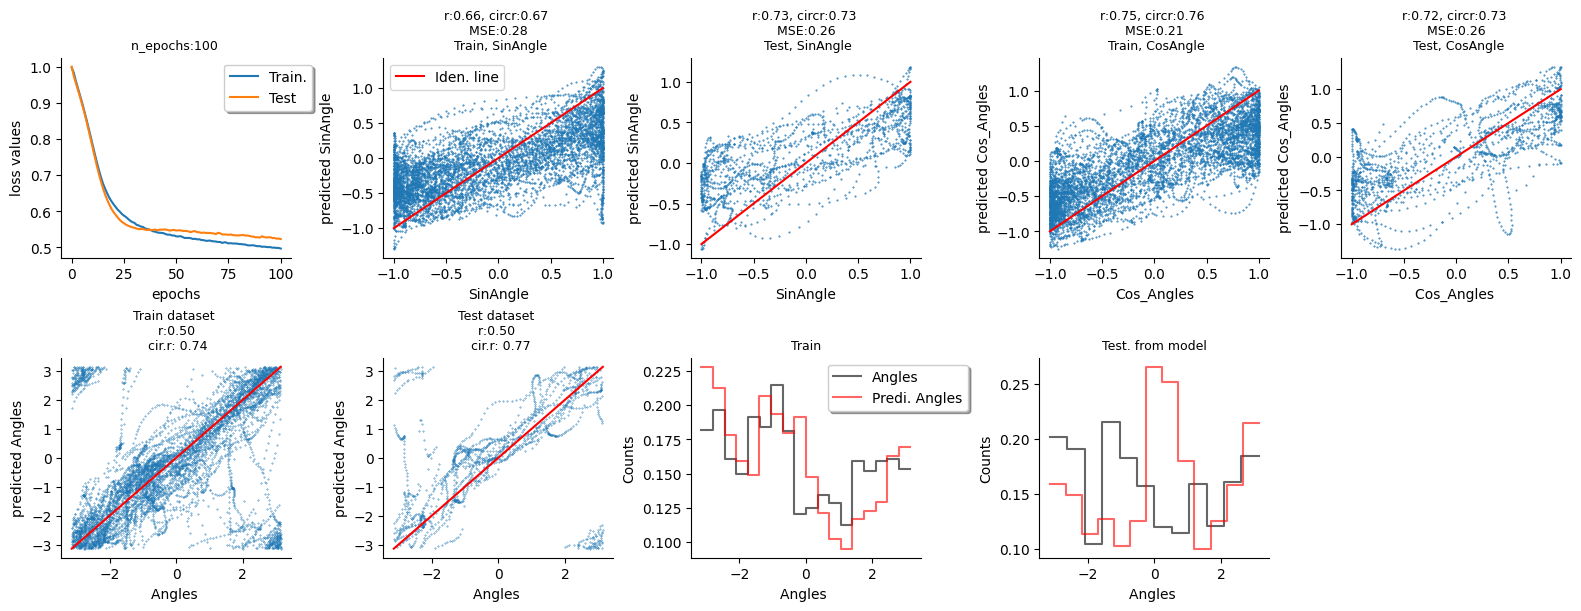

In [25]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

Plot_labes_outPuts_from_model(gs,  df, labels_test, labels_train, outputs_train, outputs_test, mse_train, mse_test)


In [20]:
def run_and_evaluate_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5, shuffle=True):
    
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:
        
        ## Get the test and train Dataset for each shuffle
        train_dataset, test_dataset, train_loader, test_loader, _, config = get_test_training_datas_oneSession(
            sSes, ses, interName, ctype=ctype, sigma_ifr=sigma_ifr, shuffle=shuffle
        )

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"], config["seq_length"], device=device).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])
        loss_fn = torch.nn.MSELoss()

        # Train the model
        df, _ = training_loop(
            n_epochs=config["num_epochs"], optimizer=optimizer, model=model,
            loss_fn=loss_fn, train_data_loader=train_loader, test_data_loader=test_loader,
            config=config, device=device, verbose=False
        )

        # Get labels and predictions
        mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_loader, device)
        mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_loader, device)

        # Calculate angles
        angles = {}

        if shuffle == True: 

            for split, labels, outputs in zip(['train', 'test'], [labels_train, labels_test], [outputs_train, outputs_test]):
                angles[f'{split}_shuffled'] = np.arctan2(labels[:, 0], labels[:, 1])
                angles[f'{split}_pred_shuffled'] = np.arctan2(outputs[:, 0], outputs[:, 1])

            # Calculate correlations
            metrics = {
                'r_train': pearsonr(angles['train_shuffled'], angles['train_pred_shuffled'])[0],
                'circr_train': circcorrcoef(angles['train_shuffled'], angles['train_pred_shuffled']),
                'r_test': pearsonr(angles['test_shuffled'], angles['test_pred_shuffled'])[0],
                'circr_test': circcorrcoef(angles['test_shuffled'], angles['test_pred_shuffled']),
                'df': df,
            }
        else:
            for split, labels, outputs in zip(['train', 'test'], [labels_train, labels_test], [outputs_train, outputs_test]):
                angles[f'{split}'] = np.arctan2(labels[:, 0], labels[:, 1])
                angles[f'{split}_pred'] = np.arctan2(outputs[:, 0], outputs[:, 1])

            # Calculate correlations
            metrics = {
                'r_train': pearsonr(angles['train'], angles['train_pred'])[0],
                'circr_train': circcorrcoef(angles['train'], angles['train_pred']),
                'r_test': pearsonr(angles['test'], angles['test_pred'])[0],
                'circr_test': circcorrcoef(angles['test'], angles['test_pred']),
                'df': df,
            }

        return {**angles, **metrics}


## Test on other sessions 

In [33]:
filtered_cells = cells[(cells['interneuron']) & (cells['mrate_RF1'] > 10)]
session_counts = filtered_cells.groupby('session').size()

# Count how many sessions have more than one FS cell meeting the criteria
num_sessions = (session_counts >= 10).sum()
sessionList = session_counts[session_counts >= 10].index.tolist()
num_sessions, sessionList


(8,
 ['jp486-01032023-0108',
  'jp486-05032023-0108',
  'jp486-07032023-0108',
  'jp486-09032023-0108',
  'jp486-10032023-0108',
  'jp486-13032023-0108',
  'jp486-15032023-0108',
  'jp486-19032023-0108'])

In [42]:
sessionList
#sesid= [sSes.name for sSes in sSessions].index(sesName)
[sSes.name for sSes in sSessions].index(sessionList[0])

146

In [44]:
sessionList[0]
Mylists=[]
for sesName in sessionList:
    Mylists.append([sSes.name for sSes in sSessions].index(sesName)) 

In [45]:
Mylists

[146, 149, 139, 152, 142, 132, 131, 140]

In [14]:
def run_evalute_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5): 
    ## get test and training dataset
    train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses,
                                                        interName, ctype= ctype, sigma_ifr= sigma_ifr, maxDistance= 18, rotationType="none", shuffle=False)
    ### get my model 
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
    print("Device available:", device)

    #optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
    optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
    loss_fn = torch.nn.MSELoss() # 
    model.train()


    ### train the model 
    df, best_model_state = training_loop(n_epochs=config["num_epochs"],
                 optimizer=optimizer,
                 model = model,
                 loss_fn = loss_fn,
                 train_data_loader=train_data_loader,
                 test_data_loader=test_data_loader, #changed to look at prediction in training dataset
                 config=config,
                 device = device,
                 verbose=True)
    
    mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
    mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)
    
    myMetrics= {'df': df, 
               'mse_test': mse_test, 
               'outputs_test': outputs_test, 
                'labels_test': labels_test, 
                'mse_train': mse_train, 
                'outputs_train': outputs_train,
                'labels_train':labels_train
               }
    return myMetrics

2024-11-07 10:01:01.124965 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
Device available: cuda
Training starting at 2024-11-07 10:01:01.145344
Test loss without training: 1.0014294385910034
2024-11-07 10:01:02.353911 Epoch: 1/100, Training loss: 0.9794080450869443, Testing loss: 0.969335046307794
2024-11-07 10:01:03.022795 Epoch: 2/100, Training loss: 0.9370375573635101, Testing loss: 0.9381518918892433
2024-11-07 10:01:03.665553 Epoch: 3/100, Training loss: 0.8946031713694856, Testing loss: 0.9059209761948421
2024-11-07 10:01:04.310224 Epoch: 4/100, Training loss: 0.8508854816880143, Testing loss: 0.8735209662338783
2024-11-07 10:01:04.953990 Epoch: 5/100, Training loss: 0.8069908875122405, Testing loss: 0.8417446757185048
2024-11-07 10:01:05.708732 Epoch: 6/100, Training loss: 0.7647094752704888, Testing loss: 0.813203581448259
2024-11-07 10:01:06.359386 Epoc

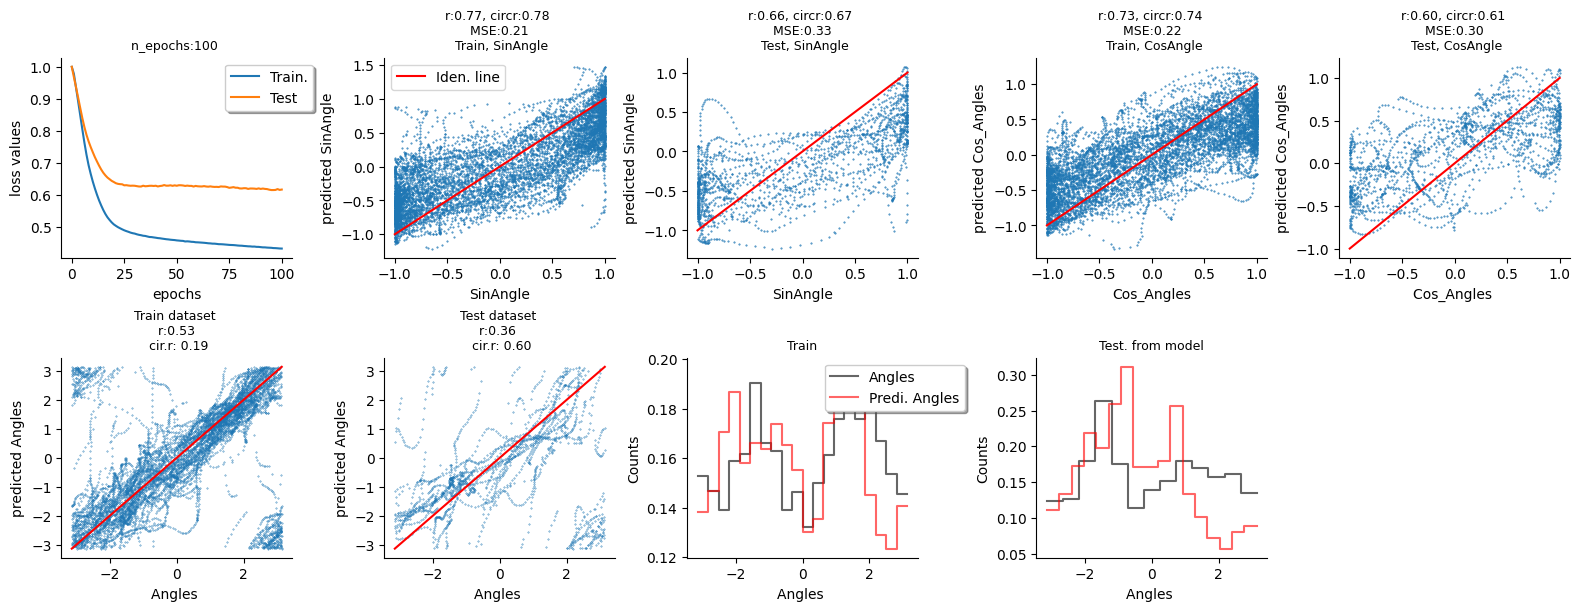

In [81]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ses= myProject.sessionList[146]
sSes= sSessions[146]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'

myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
Plot_labes_outPuts_from_model(gs,  myMetrics['df'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])


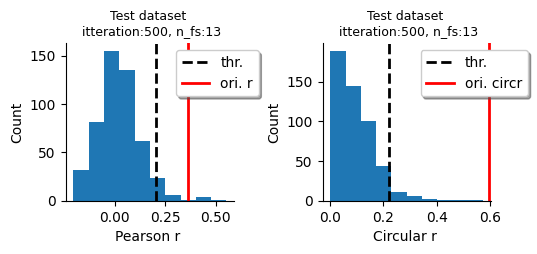

In [82]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

fn = f"Shuffled_values/{sSes.name}_{interName}_shuffled_values.pkl"
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_shuffled_rvalues_oneSession(gs,shuffle, Angle_test, Angle_test_pred ,iteration= 500 )

Test the 3d session : 


2024-11-07 10:04:55.566816 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
Device available: cuda
Training starting at 2024-11-07 10:04:55.586016
Test loss without training: 1.0063209879782893
2024-11-07 10:04:56.890047 Epoch: 1/100, Training loss: 0.9842454632443767, Testing loss: 0.9719707638986649
2024-11-07 10:04:57.603523 Epoch: 2/100, Training loss: 0.9466467240164357, Testing loss: 0.9409584364583415
2024-11-07 10:04:58.331743 Epoch: 3/100, Training loss: 0.9112030306170064, Testing loss: 0.9088265818934287
2024-11-07 10:04:59.044430 Epoch: 4/100, Training loss: 0.8748194613764363, Testing loss: 0.8748401345745209
2024-11-07 10:04:59.766951 Epoch: 5/100, Training loss: 0.8362637508300043, Testing loss: 0.8384893844204564
2024-11-07 10:05:00.475297 Epoch: 6/100, Training loss: 0.7962048769958557, Testing loss: 0.800213715722484
2024-11-07 10:05:01.178981 Epo

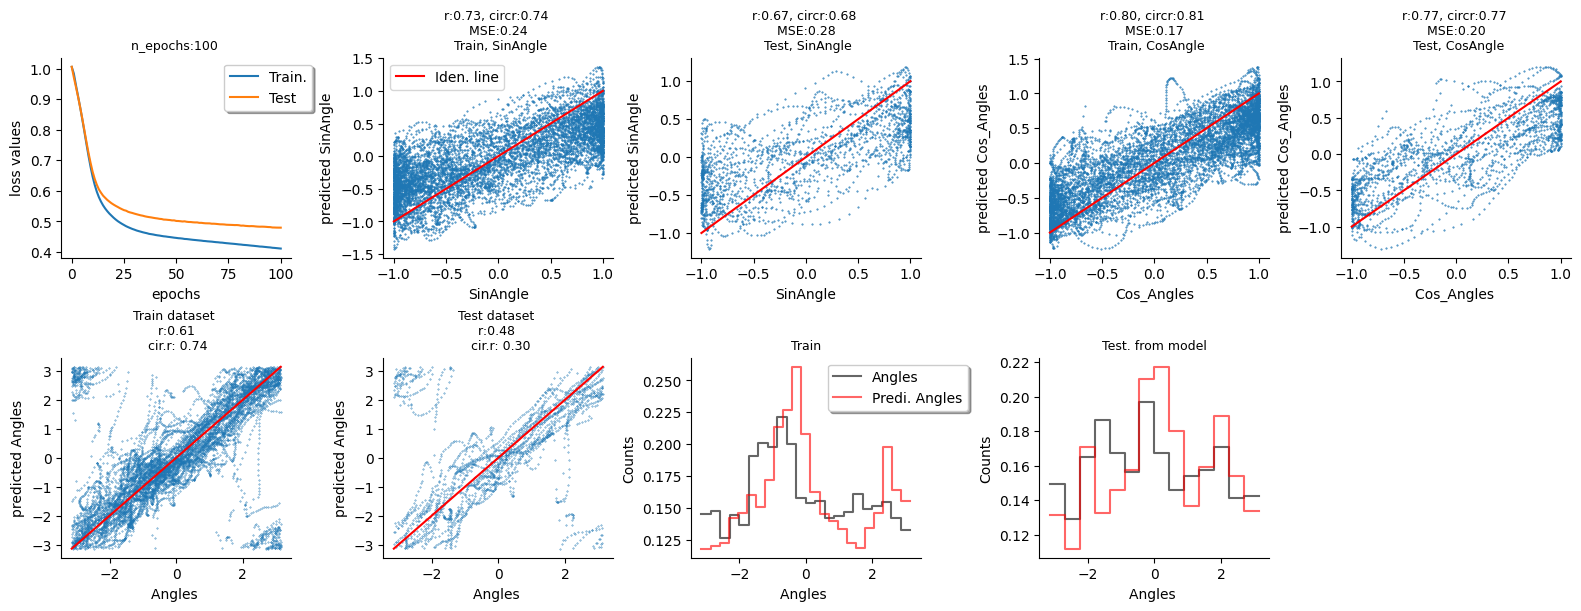

In [83]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ses= myProject.sessionList[149]
sSes= sSessions[149]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'

myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
Plot_labes_outPuts_from_model(gs,  myMetrics['df'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])


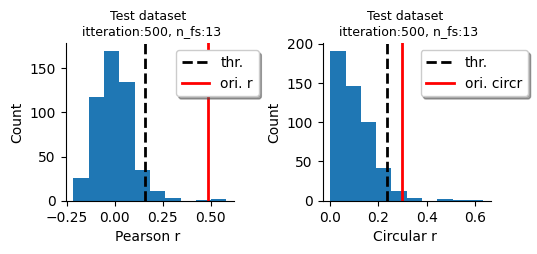

In [84]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

fn = f"Shuffled_values/{sSes.name}_{interName}_shuffled_values.pkl"
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_shuffled_rvalues_oneSession(gs,shuffle, Angle_test, Angle_test_pred ,iteration= 500 )

In [85]:
cells[(cells.session== sSes.name) & (cells.interneuron) & (cells.mrate_RF1>10)].shape

(13, 41)

In [86]:
ses13 = session_counts[session_counts >= 13].index.tolist()

In [87]:
ses13

['jp486-01032023-0108',
 'jp486-05032023-0108',
 'jp486-09032023-0108',
 'jp486-15032023-0108']

test 4ds session: 

In [ ]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ses= myProject.sessionList[139]
sSes= sSessions[139]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'

myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
Plot_labes_outPuts_from_model(gs,  myMetrics['df'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])


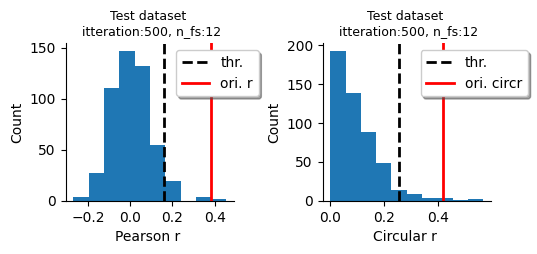

In [89]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

fn = f"Shuffled_values/{sSes.name}_{interName}_shuffled_values.pkl"
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_shuffled_rvalues_oneSession(gs,shuffle, Angle_test, Angle_test_pred ,iteration= 500 )

In [90]:
cells[(cells.session== sSes.name) & (cells.interneuron) & (cells.mrate_RF1>10)].shape

(12, 41)

2024-11-07 10:18:13.376632 {'seq_length': 20, 'n_cells': 11, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
Device available: cuda
Training starting at 2024-11-07 10:18:13.394705
Test loss without training: 1.0013543286106803
2024-11-07 10:18:14.424081 Epoch: 1/100, Training loss: 0.9878186473901245, Testing loss: 0.98257622664625
2024-11-07 10:18:15.004990 Epoch: 2/100, Training loss: 0.9705150243879734, Testing loss: 0.9718111482533541
2024-11-07 10:18:15.567125 Epoch: 3/100, Training loss: 0.9573078792670677, Testing loss: 0.9634746340188113
2024-11-07 10:18:16.113660 Epoch: 4/100, Training loss: 0.9444193983900135, Testing loss: 0.9555844041434202
2024-11-07 10:18:16.686942 Epoch: 5/100, Training loss: 0.9318642068183285, Testing loss: 0.9481020000847903
2024-11-07 10:18:17.239854 Epoch: 6/100, Training loss: 0.9191435739911836, Testing loss: 0.9408123113892295
2024-11-07 10:18:17.815345 Epoc

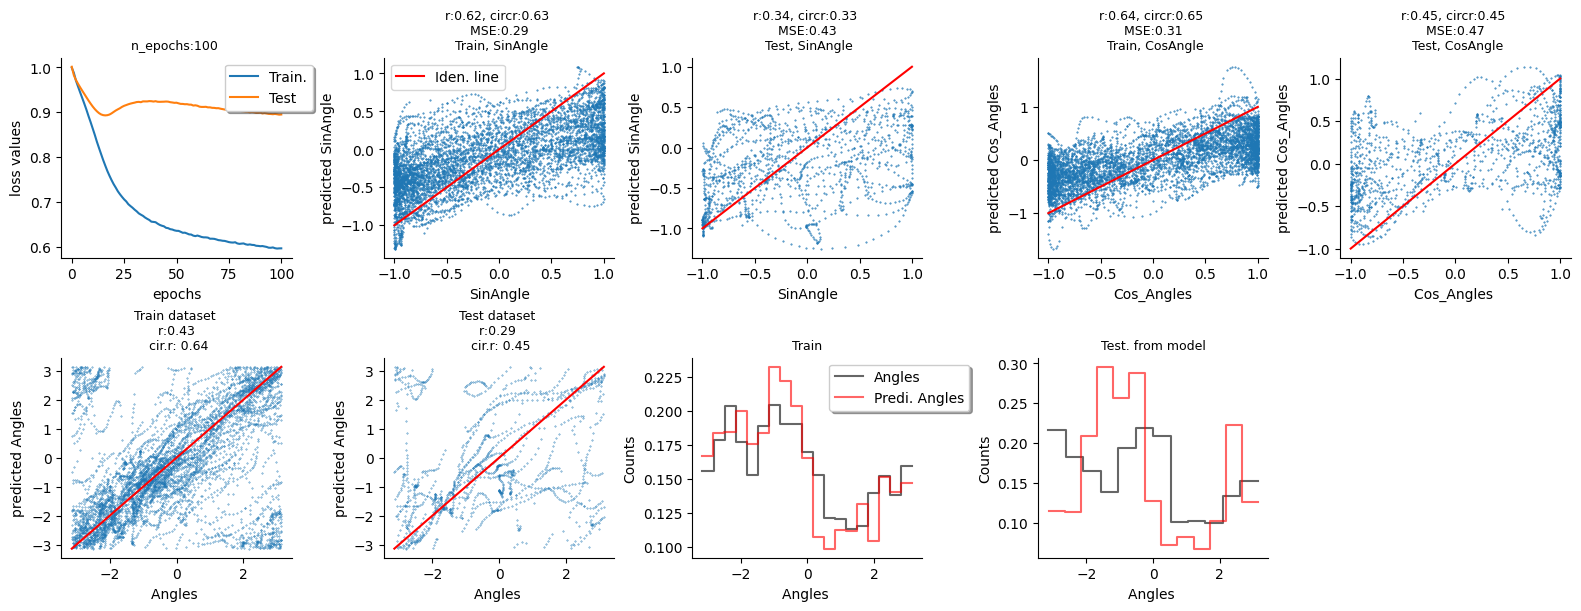

In [91]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ses= myProject.sessionList[132]
sSes= sSessions[132]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'

myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
Plot_labes_outPuts_from_model(gs,  myMetrics['df'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])


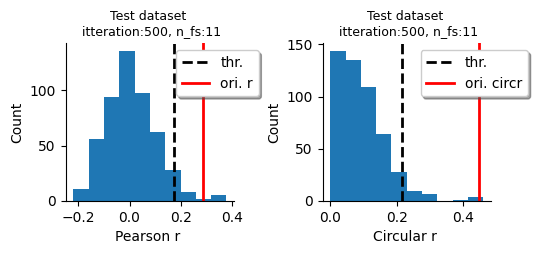

In [92]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

fn = f"Shuffled_values/{sSes.name}_{interName}_shuffled_values.pkl"
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_shuffled_rvalues_oneSession(gs,shuffle, Angle_test, Angle_test_pred ,iteration= 500 )

2024-11-07 10:22:02.118885 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
Device available: cuda
Training starting at 2024-11-07 10:22:02.137124
Test loss without training: 1.0013985574245452
2024-11-07 10:22:03.106993 Epoch: 1/100, Training loss: 0.9853377558290959, Testing loss: 0.9797487646341324
2024-11-07 10:22:03.637546 Epoch: 2/100, Training loss: 0.9617769002914429, Testing loss: 0.9656443059444427
2024-11-07 10:22:04.186732 Epoch: 3/100, Training loss: 0.9441388718783855, Testing loss: 0.9522146046161651
2024-11-07 10:22:04.714591 Epoch: 4/100, Training loss: 0.9282721452414989, Testing loss: 0.9396268576383591
2024-11-07 10:22:05.247113 Epoch: 5/100, Training loss: 0.9127099439501762, Testing loss: 0.9272388726472854
2024-11-07 10:22:05.789462 Epoch: 6/100, Training loss: 0.8980098590254784, Testing loss: 0.9153732031583786
2024-11-07 10:22:06.307139 Ep

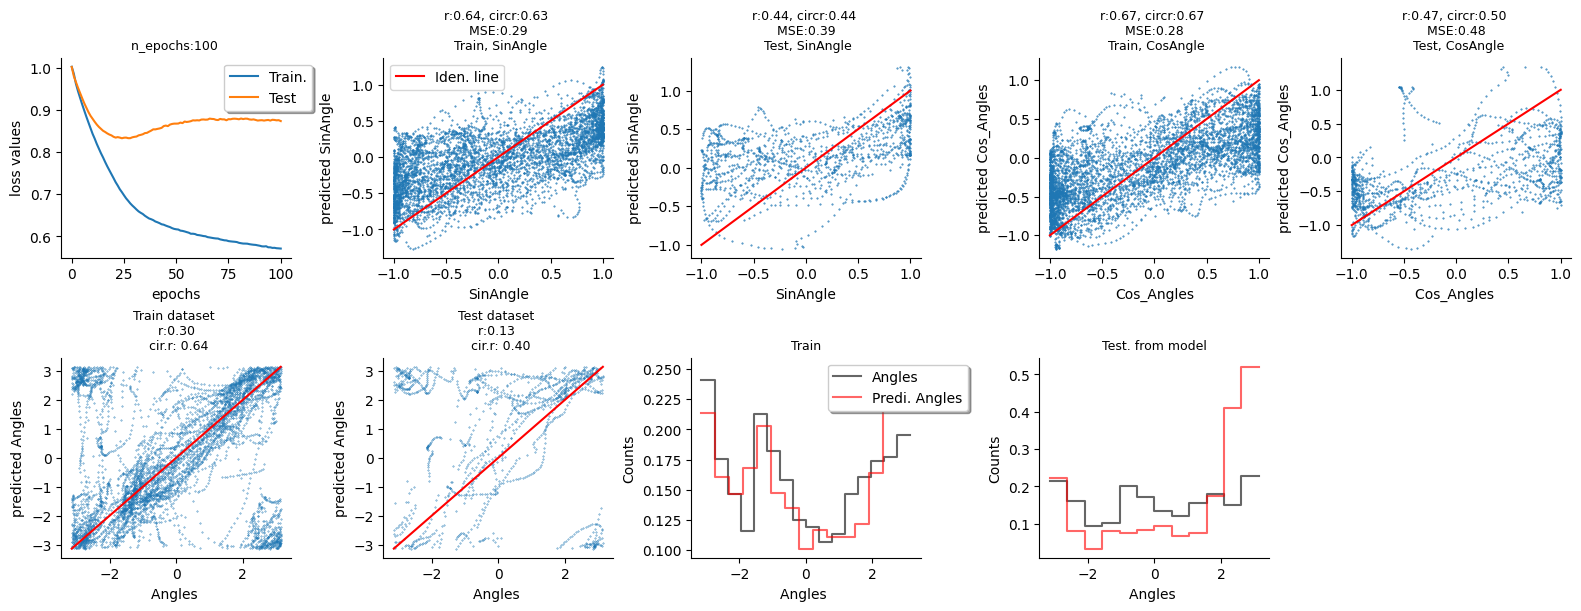

In [93]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ses= myProject.sessionList[131]
sSes= sSessions[131]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'

myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
Plot_labes_outPuts_from_model(gs,  myMetrics['df'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])


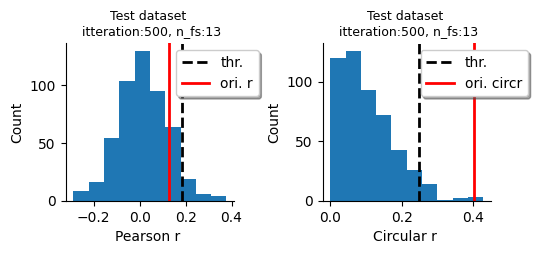

In [94]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

fn = f"Shuffled_values/{sSes.name}_{interName}_shuffled_values.pkl"
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_shuffled_rvalues_oneSession(gs,shuffle, Angle_test, Angle_test_pred ,iteration= 500 )

## Make a function to read to compare shuffeled with original model  

In [75]:
def plot_shuffled_rvalues_oneSession(gs,sessName, df_sSes, Angle_test, Angle_test_pred ,iteration= 500 ):

    
    ax= fig.add_subplot(gs[0])
    ax.hist(df_sSes.r_test)
    threshold= np.percentile(df_sSes.r_test,95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    ax.axvline(x=r_original, color='red', linestyle='-', linewidth=2, label='ori. r')
    ax.set_title(f' {sessName} \n itte.:{iteration}, n_fs:{df_sSes.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Pearson r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


    ax= fig.add_subplot(gs[1])
    ax.hist(abs(df_sSes.circr_test))
    threshold= np.percentile(abs(df_sSes.circr_test),95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    ax.axvline(x=circr, color='red', linestyle='-', linewidth=2, label='ori. circr')
    ax.set_title(f'Test dataset \n itteration:{iteration}, n_fs:{df_sSes.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Circular r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)

In [185]:
## pickle file for the original model of all session
#fn= '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Sessions_model/allSessions.pkl'
fn= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/allSessions_dfld.pkl'

dfSessions= pd.read_pickle(fn)
dfSessions

,index,session,interName,df,nfs,Angle_train,Angle_train_pred,Angle_test,Angle_test_pred,circr_test,circr_train
0,0,mn8578-05122021-0108,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[-0.05478533, 0.062889285, -0.61021197, 0.3326...","[-2.7349052, -2.7820385, -2.9908197, 0.4766188...","[-0.7068635, -0.6536218, -0.6002408, -0.552762...","[1.0278932, 0.9996761, 0.97267467, 0.9453698, ...",0.044992,0.260336
1,1,mn8578-06122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[0.25866646, 0.22801594, -0.76026475, -2.09507...","[-0.70697856, 0.31739068, -0.5533314, 2.776596...","[1.807466, 1.7327834, 1.6672599, 1.6126592, 1....","[2.2410257, 2.2119594, 2.1725218, 2.1173813, 2...",0.257727,0.083148
2,2,mn8578-07122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-0.5971179, -0.82600385, 3.0740168, -2.325464...","[-0.47369683, -0.6198919, -0.16575491, -0.3394...","[-1.1971694, -1.1859487, -1.1701932, -1.151709...","[-0.48683253, -0.4945706, -0.5108655, -0.53607...",0.451430,0.398826
3,3,mn8578-08122021-0110,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-2.243688, 2.4231393, -0.092058904, 1.403623,...","[-1.5910472, -1.5272293, 0.27617824, -1.904884...","[-1.8811148, -1.875022, -1.8849323, -1.8888004...","[-1.3006667, -1.3319247, -1.3592049, -1.384517...",0.409319,0.351754
4,4,mn8578-10122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,4,"[-3.1203675, -2.197215, -2.547077, -1.2922583,...","[2.0808086, -2.5668118, -1.9384155, 2.8108375,...","[-2.2492583, -0.8869145, -0.85080755, -0.81858...","[1.9027859, 1.9401318, 1.98932, 2.038452, 2.07...",0.459914,0.583240
...,...,...,...,...,...,...,...,...,...,...,...
301,148,jp499-17052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,2,"[-2.2957647, -0.8533346, -1.5508065, 0.3979570...","[-1.6802485, -0.9772031, -0.5046469, -1.751059...","[-0.2496265, -0.2453315, -0.2399355, -0.234260...","[-1.5998276, -1.584808, -1.5617284, -1.5316858...",0.051345,0.137060
302,149,jp499-23052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,5,"[1.0758653, -0.19583806, -2.8547707, -0.229618...","[-0.697652, -0.6122384, -2.5940232, -0.2965195...","[-2.9092047, -2.9465926, -2.9934006, -3.039627...","[1.9315698, 1.8919411, 1.8581593, 1.8290914, 1...",0.187053,0.527122
303,150,jp499-24052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,9,"[-0.9410951, 0.54008853, 0.5556197, 0.53921527...","[-0.983582, -0.7370983, -0.74676526, 2.9604454...","[-0.20676759, -0.24085288, -0.2837893, -0.3364...","[-0.20530808, -0.15750234, -0.10203931, -0.043...",0.453954,0.532624
304,151,jp499-18052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,4,"[-2.7955167, 2.3539667, -2.4371078, -1.4491835...","[-1.6691586, 0.3915908, -1.2496557, -1.6503128...","[-0.7562389, -0.7241915, -0.64755017, -0.59298...","[-0.3755715, -0.41182712, -0.508096, -0.663541...",0.008717,0.298438


In [187]:
dfSessions.keys()

Index(['index', 'session', 'interName', 'df', 'nfs', 'Angle_train',
       'Angle_train_pred', 'Angle_test', 'Angle_test_pred', 'circr_test',
       'circr_train'],
      dtype='object')

In [189]:
# Define a function to calculate Pearson correlation
def calculate_r_test(row):
    r, _ = pearsonr(row['Angle_test'], row['Angle_test_pred'])
    return r

def calculate_r_train(row):
    r, _ = pearsonr(row['Angle_train'], row['Angle_train_pred'])
    return r

# Apply the functions to the DataFrame
dfSessions['r_test'] = dfSessions.apply(calculate_r_test, axis=1)
dfSessions['r_train'] = dfSessions.apply(calculate_r_train, axis=1)


In [190]:
dfSessions

,index,session,interName,df,nfs,Angle_train,Angle_train_pred,Angle_test,Angle_test_pred,circr_test,circr_train,r_test,r_train
0,0,mn8578-05122021-0108,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[-0.05478533, 0.062889285, -0.61021197, 0.3326...","[-2.7349052, -2.7820385, -2.9908197, 0.4766188...","[-0.7068635, -0.6536218, -0.6002408, -0.552762...","[1.0278932, 0.9996761, 0.97267467, 0.9453698, ...",0.044992,0.260336,-0.286297,0.157174
1,1,mn8578-06122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[0.25866646, 0.22801594, -0.76026475, -2.09507...","[-0.70697856, 0.31739068, -0.5533314, 2.776596...","[1.807466, 1.7327834, 1.6672599, 1.6126592, 1....","[2.2410257, 2.2119594, 2.1725218, 2.1173813, 2...",0.257727,0.083148,0.158053,0.185566
2,2,mn8578-07122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-0.5971179, -0.82600385, 3.0740168, -2.325464...","[-0.47369683, -0.6198919, -0.16575491, -0.3394...","[-1.1971694, -1.1859487, -1.1701932, -1.151709...","[-0.48683253, -0.4945706, -0.5108655, -0.53607...",0.451430,0.398826,0.158318,0.232374
3,3,mn8578-08122021-0110,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-2.243688, 2.4231393, -0.092058904, 1.403623,...","[-1.5910472, -1.5272293, 0.27617824, -1.904884...","[-1.8811148, -1.875022, -1.8849323, -1.8888004...","[-1.3006667, -1.3319247, -1.3592049, -1.384517...",0.409319,0.351754,0.402051,0.213557
4,4,mn8578-10122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,4,"[-3.1203675, -2.197215, -2.547077, -1.2922583,...","[2.0808086, -2.5668118, -1.9384155, 2.8108375,...","[-2.2492583, -0.8869145, -0.85080755, -0.81858...","[1.9027859, 1.9401318, 1.98932, 2.038452, 2.07...",0.459914,0.583240,0.501421,0.474051
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,148,jp499-17052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,2,"[-2.2957647, -0.8533346, -1.5508065, 0.3979570...","[-1.6802485, -0.9772031, -0.5046469, -1.751059...","[-0.2496265, -0.2453315, -0.2399355, -0.234260...","[-1.5998276, -1.584808, -1.5617284, -1.5316858...",0.051345,0.137060,-0.124892,0.061712
302,149,jp499-23052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,5,"[1.0758653, -0.19583806, -2.8547707, -0.229618...","[-0.697652, -0.6122384, -2.5940232, -0.2965195...","[-2.9092047, -2.9465926, -2.9934006, -3.039627...","[1.9315698, 1.8919411, 1.8581593, 1.8290914, 1...",0.187053,0.527122,0.397254,0.410371
303,150,jp499-24052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,9,"[-0.9410951, 0.54008853, 0.5556197, 0.53921527...","[-0.983582, -0.7370983, -0.74676526, 2.9604454...","[-0.20676759, -0.24085288, -0.2837893, -0.3364...","[-0.20530808, -0.15750234, -0.10203931, -0.043...",0.453954,0.532624,0.438679,0.412614
304,151,jp499-18052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,4,"[-2.7955167, 2.3539667, -2.4371078, -1.4491835...","[-1.6691586, 0.3915908, -1.2496557, -1.6503128...","[-0.7562389, -0.7241915, -0.64755017, -0.59298...","[-0.3755715, -0.41182712, -0.508096, -0.663541...",0.008717,0.298438,0.249851,0.257661


In [ ]:
directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/500_shuffle/'

file_names = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
SessionList= [f.split('_')[0] for f in file_names]
SesIndxs= [[sSes.name for sSes in sSessions].index(sesName) for sesName in SessionList ]

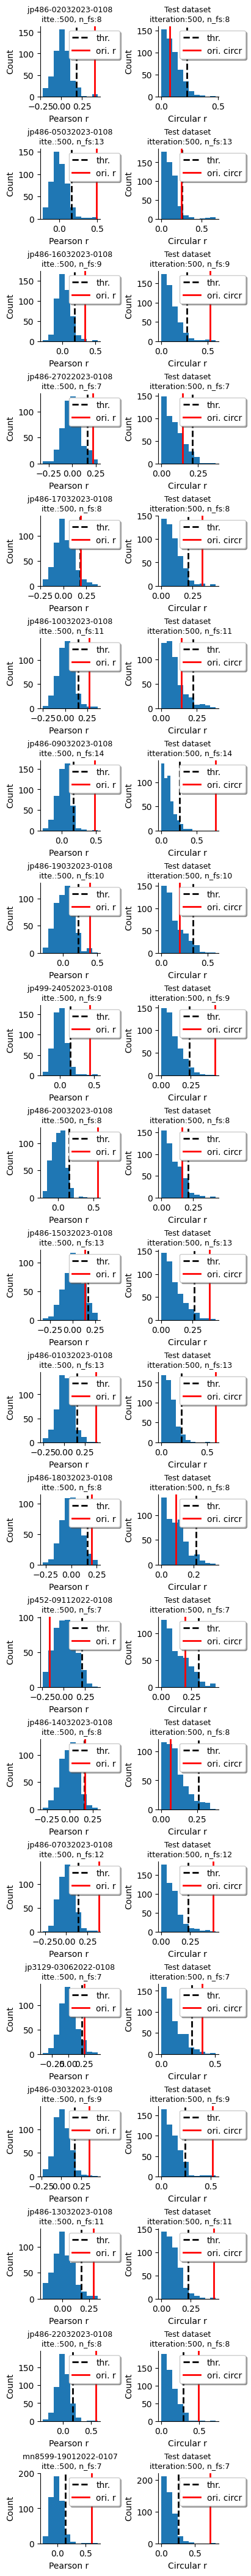

In [77]:
col = 2
row = len(SesIndxs)
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


for i, (sesind, f) in enumerate(zip(SesIndxs, file_names)): 
    #print(i, sesind)
    sSes= sSessions[sesind]
    ses= myProject.sessionList[sesind]
    
    mymodel= allSessions_df[allSessions_df.session== sSes.name]
    fn= directory + f
    shuffle= pd.read_pickle(fn)
    #threshold= np.percentile(shuffle.r_test,95)
    
    gsi = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i,:])#, width_ratios=[1.5,2,1,1])
    plot_shuffled_rvalues_oneSession(gsi,sSes.name, shuffle, mymodel.Angle_test.iloc[0], mymodel.Angle_test_pred.iloc[0],iteration= 500 )

In [100]:
mydata=[]

for i, (sesind, f) in enumerate(zip(SesIndxs, file_names)): 

    sSes= sSessions[sesind]
    ses= myProject.sessionList[sesind]
    
    mymodel= allSessions_df[allSessions_df.session== sSes.name]
    fn= directory + f
    shuffle= pd.read_pickle(fn)
    threshold= np.percentile(shuffle.r_test,95)

    Angle_test= mymodel.Angle_test.iloc[0]
    Angle_test_pred= mymodel.Angle_test_pred.iloc[0]
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    
    threshold_circr= np.percentile(abs(shuffle.circr_test),95)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    
    data= { 'session': sSes.name,
            'sesInd': sesind,
            'Angle_test': Angle_test, 
            'Angle_test_pred': Angle_test_pred, 
            'r_original': r_original, 
            'threshold': threshold, 
            'nfs': mymodel.nfs.iloc[0],
            'threshold_circr':threshold_circr,
            'circr': circr 
               }
    mydata.append(data)

In [103]:
shuffled_sessions_500= pd.DataFrame(mydata)
shuffled_sessions_500['Model'] = shuffled_sessions['r_original'] > shuffled_sessions['threshold']
shuffled_sessions_500['Model_circr'] = shuffled_sessions['circr'] > shuffled_sessions['threshold_circr']


In [104]:
shuffled_sessions_500

,session,sesInd,Angle_test,Angle_test_pred,r_original,threshold,nfs,threshold_circr,circr,Model,Model_circr
0,jp486-02032023-0108,148,"[0.30122444, 0.267327, 0.2176589, 0.1582937, 0...","[-0.5464293, -0.5450411, -0.5380126, -0.526335...",0.400884,0.184665,8,0.223957,0.073842,True,False
1,jp486-05032023-0108,149,"[1.2644589, 0.98865324, 0.8027675, 0.7500945, ...","[1.4151291, 1.3105843, 1.2114877, 1.1185664, 1...",0.489191,0.163411,13,0.256061,0.248970,True,False
2,jp486-16032023-0108,133,"[-1.1931248, -1.2216395, -1.249797, -1.2702776...","[-0.8122229, -0.7829924, -0.7569534, -0.735951...",0.338053,0.183557,9,0.278895,0.527427,True,True
3,jp486-27022023-0108,145,"[-1.0331383, -1.0983062, -1.1527146, -1.198476...","[0.39692622, 0.28924224, 0.17644213, 0.0631173...",0.218248,0.163137,7,0.211958,0.143622,True,False
4,jp486-17032023-0108,147,"[0.9584309, 0.95344806, 0.94477445, 0.9357167,...","[-0.650245, -0.71379256, -0.7733788, -0.828318...",0.184616,0.183480,8,0.211606,0.322859,True,True
5,jp486-10032023-0108,142,"[-1.4615567, -1.5126357, -1.5586389, -1.588057...","[2.8566573, 2.776146, 2.6869116, 2.5884242, 2....",0.272015,0.149432,11,0.223863,0.140598,True,False
6,jp486-09032023-0108,152,"[-0.5865606, -0.6278765, -0.6709168, -0.715618...","[-0.7643935, -0.78100175, -0.776353, -0.732839...",0.484371,0.171439,14,0.259627,0.775270,True,True
7,jp486-19032023-0108,140,"[0.9770612, 0.90370363, 0.81935465, 0.75313705...","[0.6117784, 0.5793635, 0.54513365, 0.50864375,...",0.389031,0.219982,10,0.339967,0.198838,True,False
8,jp499-24052023-0108,176,"[-0.20676759, -0.24085288, -0.2837893, -0.3364...","[-0.20530808, -0.15750234, -0.10203931, -0.043...",0.438679,0.153490,9,0.240153,0.453954,True,True
9,jp486-20032023-0108,130,"[1.4813715, 1.4050401, 1.3296566, 1.2413428, 1...","[1.4049559, 1.4004766, 1.3871888, 1.3631299, 1...",0.555484,0.155331,8,0.213406,0.163566,True,False


In [ ]:
## Plot the session 